In [14]:
import joblib
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker

config = get_config()
conn_dir = config["connectivity_matrices"]

REFNET = ("Default",)
INTER = ("Default",)

sns.reset_defaults()

In [15]:
ATLAS = "schaefer200"
k = 3

import os
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(
    config["output_dir"], k=k, feat="fc", atlas=ATLAS, groupkfold=False, net="".join(REFNET), inter="".join(INTER)
)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 8 subjects because of lacking MMMSE


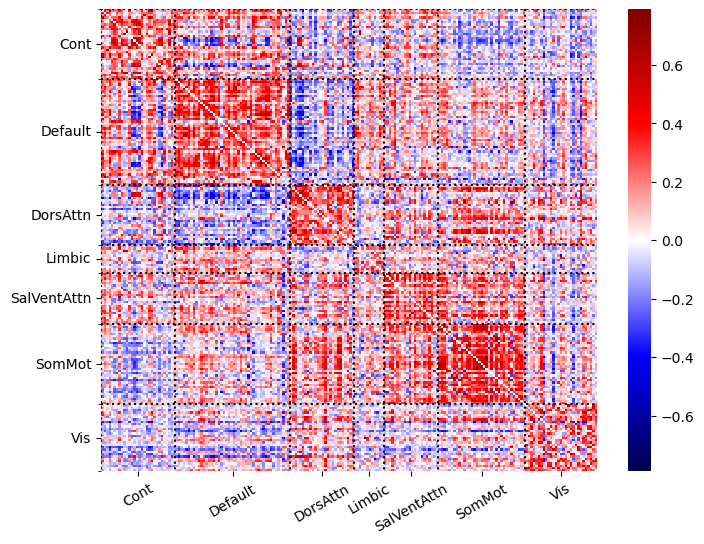

In [16]:
from neuroginius.atlas import Atlas
plot_matrix(matrices[1], Atlas.from_name(ATLAS))
plt.show()

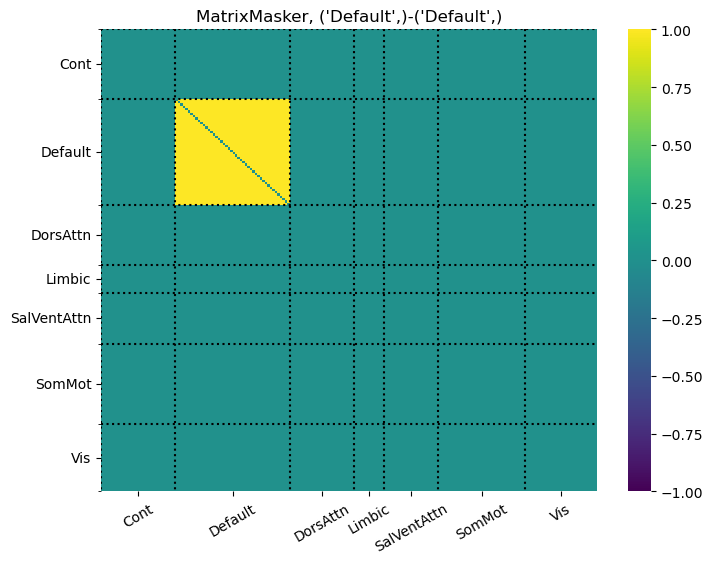

In [17]:
masker = MatrixMasker(REFNET, INTER).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

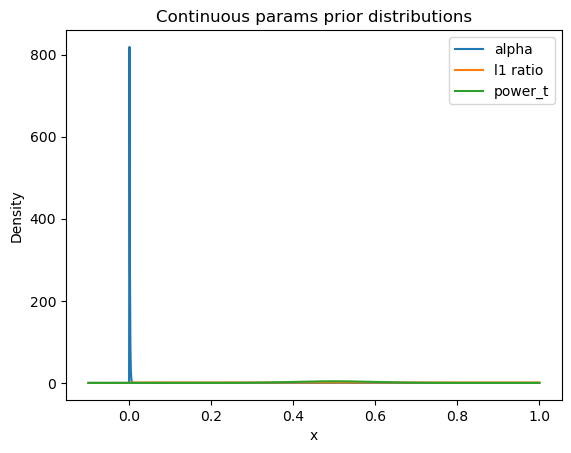

In [18]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [19]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, cross_val_score, StratifiedGroupKFold
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER)),
    ("scaler", preprocessing.StandardScaler()),
    #("reduction", PCA()),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [21]:
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
67,1.208450,0.228070,0.050676,0.029046,0.000019,0.413347,log_loss,0.531562,"{'classifier__alpha': 1.8760892613954563e-05, ...",0.368878,0.590909,0.424528,0.393927,0.275856,0.303308,0.316730,0.370549,0.380586,0.091924,1
70,1.809630,0.252284,0.049183,0.028871,0.002282,0.834925,hinge,0.441116,"{'classifier__alpha': 0.002281727544430136, 'c...",0.334464,0.590909,0.438393,0.351340,0.333691,0.307002,0.376851,0.309542,0.380274,0.088906,2
76,2.188760,0.627161,0.049596,0.028868,0.001422,0.934562,modified_huber,0.480626,"{'classifier__alpha': 0.0014218255588621987, '...",0.396201,0.543396,0.424158,0.322385,0.323167,0.277815,0.348469,0.338387,0.371747,0.077527,3
13,1.001301,0.097293,0.053139,0.031577,0.000084,0.993549,hinge,0.620199,"{'classifier__alpha': 8.400384825507838e-05, '...",0.385367,0.496296,0.473469,0.371325,0.340321,0.275986,0.327687,0.298947,0.371175,0.073690,4
26,1.468849,0.250231,0.049647,0.028829,0.000801,0.829174,log_loss,0.637829,"{'classifier__alpha': 0.0008013551629935216, '...",0.371798,0.565432,0.317230,0.360290,0.331111,0.299571,0.356968,0.345868,0.368533,0.077688,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.799977,0.947368,0.055983,0.031541,0.001805,0.920590,modified_huber,0.646551,"{'classifier__alpha': 0.001805223839408241, 'c...",0.384581,0.415385,0.296923,0.331904,0.320471,0.276989,0.346611,0.305003,0.334733,0.043287,96
98,1.552109,0.164575,0.052010,0.032330,0.004184,0.673848,hinge,0.400092,"{'classifier__alpha': 0.004184333345290324, 'c...",0.309834,0.417284,0.289562,0.345742,0.356167,0.309514,0.319247,0.315200,0.332819,0.037556,97
0,6.967650,1.608678,0.148964,0.031598,0.001740,0.984627,log_loss,0.587207,"{'classifier__alpha': 0.0017402311925260737, '...",0.394875,0.395722,0.276049,0.364033,0.285742,0.271099,0.334457,0.331075,0.331632,0.047467,98
68,3.575868,0.962338,0.049626,0.026604,0.000971,0.993877,log_loss,0.508933,"{'classifier__alpha': 0.0009713204162961679, '...",0.396593,0.397942,0.275737,0.339823,0.286581,0.272541,0.344975,0.325462,0.329957,0.046802,99


In [22]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [36]:
def net_select(label):
    if label == masker.refnet[0]:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network == masker.refnet[0]:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

In [35]:
MockAtlas().macro_labels

[]

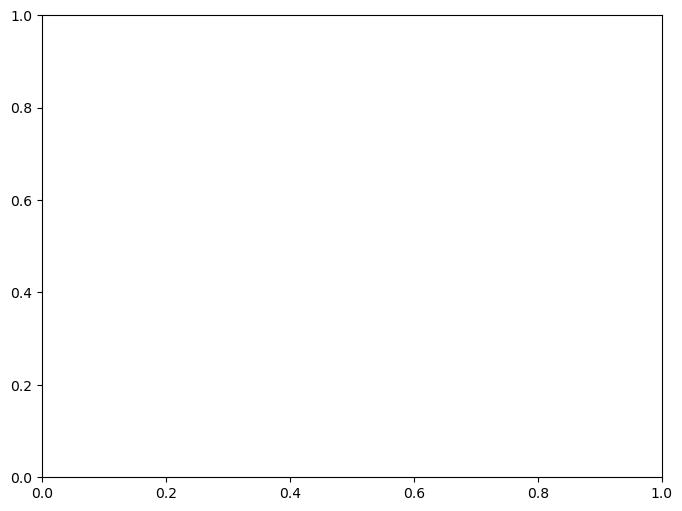

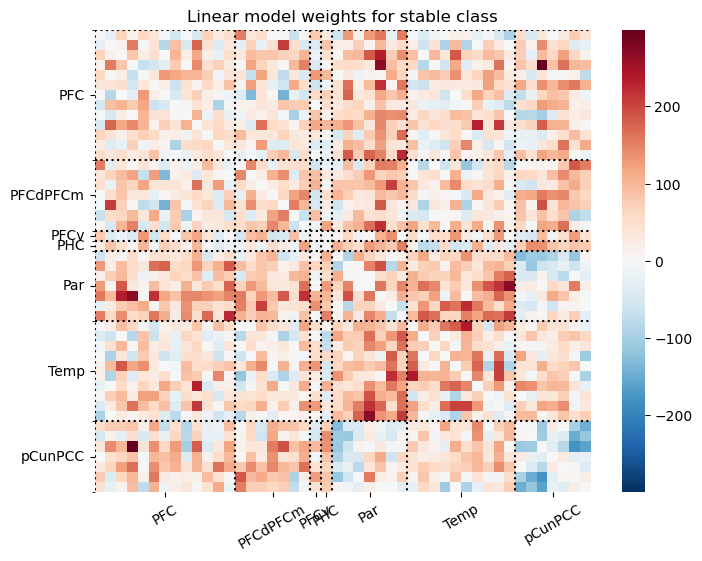

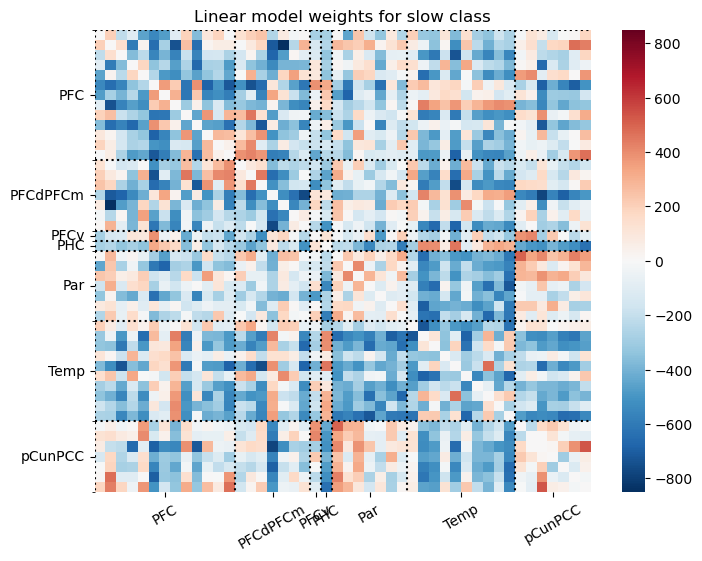

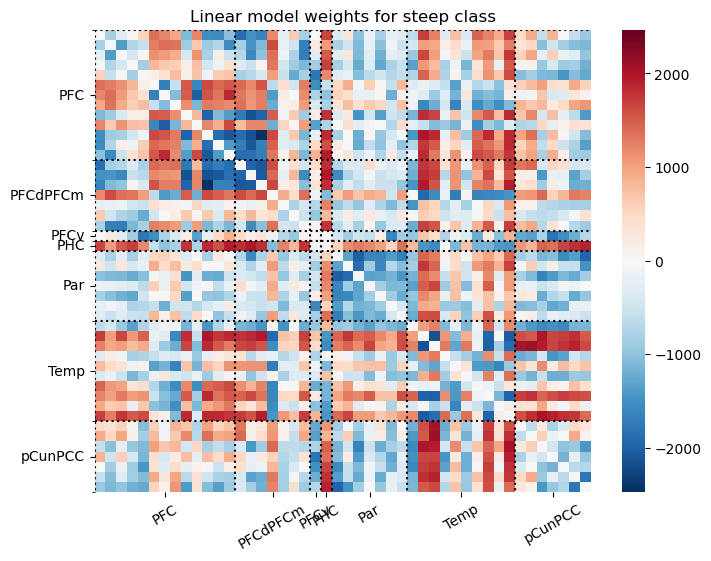

In [37]:
from nilearn.connectome import vec_to_sym_matrix
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    macro_labels = list(map(region_split, regions))
    
# TODO What would happen if we inverse-transformed the coefs?
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    X = est.named_steps["scaler"].transform(X)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        #bounds=(-4, 4)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

In [38]:
test_scores = cross_val_score(
    search,
    matrices,
    y,
    cv=outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.32940821, 0.43905724, 0.36958055, 0.36459836, 0.30422478,
       0.3078989 , 0.31015983, 0.33786342])

In [39]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default/best_estimator.joblib']